In [ ]:
# # Comment the following lines if you're not in colab:
# from google.colab import drive
# drive.mount('/content/drive')
# # If you're in colab, cd to your own working directory here:
# %cd ..//..//content//drive//MyDrive//Colab-Notebooks//HY-673-Tutorials//Tutorial-9

In [ ]:
# Python:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
# PyTorch
import torch as tc
import torch.nn as nn
from torch.optim import Adam
from torchsummary import summary
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
# RNG, Type, Device:
seed = 42
np.random.seed(seed)
tc.manual_seed(seed)
tc.set_default_dtype(tc.float32)
device = 'cuda' if tc.cuda.is_available() else 'cpu'
print(f"using {device}")

using cuda


# <u>Simple Diffusion Model</u>
In this notebook we build a simple diffusion model for MNIST digit generation. The scheduler we explained in the previous notebook is:

In [ ]:
def get_schedules(beta_1, beta_t, timesteps):
    """
    Linear scheduler.
    Useful to pre-compute all the parameters (even fractions, square roots, etc).
    """
    beta_t = (beta_t - beta_1) * tc.arange(0, timesteps + 1, dtype=tc.float32) / timesteps + beta_1
    sqrt_beta_t = tc.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = tc.log(alpha_t)
    alphabar_t = tc.cumsum(log_alpha_t, dim=0).exp()
    sqrt_abar = tc.sqrt(alphabar_t)
    one_over_sqrt_a = 1 / tc.sqrt(alpha_t)
    sqrt_inv_abar = tc.sqrt(1 - alphabar_t)
    inv_abar_over_sqrt_inv_abar = (1 - alpha_t) / sqrt_inv_abar
    return {
        "alpha": alpha_t,
        "one_over_sqrt_a": one_over_sqrt_a,
        "sqrt_beta": sqrt_beta_t,
        "alphabar": alphabar_t,
        "sqrt_abar": sqrt_abar,
        "sqrt_inv_abar": sqrt_inv_abar,
        "inv_alpha_over_sqrt_inv_abar": inv_abar_over_sqrt_inv_abar,
    }

# <u>U-Net</u>
Our architecture choice for this diffusion model will be what is called a **U-Net**, which has similar concepts with the one we implemented in our VAE tutorial. It is a type of CNN that was initially developed for biomedical image segmentation tasks. Its architecture is characterized by a symmetric shape which gives it the "U" name. Its fundamentals are:

1) **Contracting Path/Encoder (Downsampling):** This is the left side of the U, where the input image goes through several layers of convolutions and pooling operations. This path is responsible for capturing the context of the input image. The downsampling helps the network understand what features are present in the image, albeit at a reduced resolution. <br>
2) **Expansive Path/Decoder (Upsampling):** This is the right side of the U, which consists of transposed convolutions and concatenation followed by regular convolutions. The purpose of this path is to enable precise localization using the contextual information gained from the contracting path, allowing for high-resolution segmentation output. <br>
3) **Skip Connections:** One distinctive feature of the U-Net is the use of skip connections. These provide a pathway to carry information directly from the encoder layers to the corresponding decoder layers. This helps to recover the spatial context lost during the downsampling operations, which is critical for tasks like image segmentation where precise boundaries and localization are necessary.

![](fig/unet.jpg)
![](https://drive.google.com/uc?export=view&id=1m6X5p3Qt4akEiN6KCXJORxFkRJXLAFUu)

## <u>U-Net Block</u>
+ The elementary building block for our U-Net that preserves dimensionality. It applies convolution to extract features, followed by normalization and activation.

+ It uses group normalization (https://arxiv.org/pdf/1803.08494.pdf) which is very similar to batch normalization with the only difference that the input channels are separated into groups, each containing `num_channels/num_groups` channels.

In [ ]:
class ConvBlock(nn.Module):
    """The elementary U-Net block."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=1, padding=1
            ),
            nn.GroupNorm(num_groups=8, num_channels=out_channels),
            nn.PReLU(),
        )

    def forward(self, x):
        return self.block(x)

## <u>Encoder</u>

The encoder is responsible for taking the input image and progressively compressing it into a smaller, denser representation, i.e., the latent space. This will be done through a series of convolutional layers and downsampling layers (i.e., maximum pooling).
+ **UnetDown:** Applied the ConvBlock followed by MaxPooling to reduce the spatial dimensions, increasing the abstraction level.
+ **Sequential Layers:** They progressively increase the depth while reducing the spatial dimensions, capturing the most essential features in the latent space.

In [ ]:
class UnetDown(nn.Module):
    """The elementary encoder block."""
    def __init__(self, in_channels, out_channels, downscale=2):
        super(UnetDown, self).__init__()
        self.model = nn.Sequential(
            ConvBlock(in_channels=in_channels, out_channels=out_channels),
            nn.MaxPool2d(kernel_size=downscale)
        )
    def forward(self, x):
        return self.model(x)

class Encoder(nn.Module):
    def __init__(self, n_features):
        super(Encoder, self).__init__()
        self.initial_features = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=n_features,
                kernel_size=3, stride=1, padding=1
            ),
            nn.GroupNorm(num_groups=8, num_channels=n_features),
            nn.PReLU(),
        )
        self.down1 = UnetDown(
            in_channels=n_features, out_channels=n_features, downscale=2
        )
        self.down2 = UnetDown(
            in_channels=n_features, out_channels=2*n_features, downscale=2
        )
        self.down3 = UnetDown(
            in_channels=2*n_features, out_channels=2*n_features, downscale=2
        )
        self.down4 = nn.Sequential(
            nn.AvgPool2d(kernel_size=3),
            nn.PReLU()
        )

    def forward(self, x):
        x_f = self.initial_features(x)
        d1 = self.down1(x_f)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        latent = self.down4(d3)
        return x_f, d1, d2, d3, latent

## <u>Decoder</u>

The decoder performs the inverse operations of the encoder, making the compact latent representation and progressively reconstructing the original image's spatial dimensions and detail. It uses skip connections from the encoder to improve the reconstruction quality, which helps in recovering fine details that might be lost during encoding. In some cases, output padding is needed, e.g., on the second layer, with upscale 2 we get Cx3x3--> C'x6x6, so we need extra_dim 1 to get C'x7x7.
+ **UnetUp:** Performs upsampling and convolution. It combines features from the encoder via skip connections, helping to restore spatial details.
+ **ConvTranspose2d:** Used within UnetUp for upsampling the feature maps.
+ **Final Convolution:** The final layer that maps the high-level features back to the image space, producing the reconstructed or generated image.


In [ ]:
class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels, upscale=2, extra_dim=0):
        super(UnetUp, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=upscale, stride=upscale, output_padding=extra_dim
            ),
            nn.PReLU(),
            ConvBlock(in_channels=out_channels, out_channels=out_channels),
        )

    def forward(self, x, skip):
        x = tc.cat((x, skip), 1)
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, n_features):
        super(Decoder, self).__init__()
        # first decoder layer does not have any skip connections:
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=2*n_features, out_channels=2*n_features,
                kernel_size=3, stride=3
            ),
            nn.GroupNorm(num_groups=8, num_channels=2*n_features),
            nn.PReLU(),
        )
        self.up2 = UnetUp(
            in_channels=4*n_features, out_channels=2*n_features,
            upscale=2, extra_dim=1
        )
        self.up3 = UnetUp(
            in_channels=4*n_features, out_channels=n_features,
            upscale=2
        )
        self.up4 = UnetUp(
            in_channels=2*n_features, out_channels=n_features,
            upscale=2
        )
        self.out = nn.Conv2d(
            in_channels=2*n_features, out_channels=1,
            kernel_size=3, stride=1, padding=1
        )

    def forward(self, latent, d3, d2, d1, x_f):
        u1 = self.up1(latent)
        u2 = self.up2(u1, d3)
        u3 = self.up3(u2, d2)
        u4 = self.up4(u3, d1)
        return self.out(tc.cat([u4, x_f], dim=1))

## <u>Time Embedding</u>

We need to encode the notion of time or steps within the diffusion process. The temporal information is crucial in a diffusion model as it adjusts the network's behavior across different stages of the diffusion process (from noise to image reconstruction)
+ **Linear Layers with Sine Activation:** These layers transform a scalar time step into a high-dimensional representation, using the sine function for periodic activation which is beneficial in capturing cyclic patterns in time-dependent data.

In [ ]:
# Time embedding layer
class TimeEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super(TimeEmbedding, self).__init__()
        self.embedding_dim = embedding_dim
        self.lin1 = nn.Linear(in_features=1, out_features=embedding_dim, bias=False)
        self.lin2 = nn.Linear(in_features=embedding_dim, out_features=embedding_dim)

    def forward(self, ts):
        ts = ts.view(-1, 1)
        t_emb = tc.sin(self.lin1(ts))
        t_emb = self.lin2(t_emb)
        # add dummy channels to sum with latent:
        return t_emb.view(-1, self.embedding_dim, 1, 1)

## <u>Overall Diffusion Model</u>

Finally, we integrate the encoder, decoder, and time embedding components into a cohesive model, and add a sampling function for our diffusion model like we said on the previous notebook.

In [ ]:
class DiffusionModel(nn.Module):
    def __init__(self, n_features=64):
        super(DiffusionModel, self).__init__()
        self.encoder = Encoder(n_features=n_features)
        self.decoder = Decoder(n_features=n_features)
        self.time_embedding_layer = TimeEmbedding(embedding_dim=2*n_features)

    def forward(self, x, t):
        # pass through encoder:
        x_f, d1, d2, d3, latent = self.encoder(x)
        # get time embedding:
        latent_t_emb = latent + self.time_embedding_layer(t)
        # path through decoder:
        return self.decoder(latent_t_emb, d3, d2, d1, x_f)

    def sample(self, n_samples, timesteps, sample_shape):
        x_t = tc.randn(n_samples, *sample_shape).to(device)
        ones = tc.ones(n_samples).to(device)
        x_i = x_t
        for i in tqdm(range(timesteps, 0, -1)):
            z = tc.randn(n_samples, *sample_shape).to(device) if i > 1 else 0
            t = (i / timesteps) * ones
            eps = self.forward(x_i, t).clone().detach()
            v = schedules["one_over_sqrt_a"][i] * (x_i - eps * schedules["inv_alpha_over_sqrt_inv_abar"][i])
            x_i = v + schedules["sqrt_beta"][i] * z
        return x_i.cpu().detach().numpy().reshape(n_samples, *sample_shape).squeeze(1)

## <u>Hyperparameters & Dataset</u>
Just like in previous tutorials:

In [ ]:
length, height = 28, 28  # MNIST is 28*28 images
input_shape = (1, height, length)
no_features = 128
epochs = 100
batch_size = 64
lr = 1e-5
n_T = 1000
betas = [1e-4, 0.02]

transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
dataset = MNIST("./data", train=True, download=True, transform=transform,)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

100%|██████████| 9912422/9912422 [00:01<00:00, 9114146.68it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 5228352.27it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 4272832.55it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4533681.29it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



## <u>Model & Noise Schedule</u>

We will use MSE loss for $\epsilon$ and $\hat{\epsilon}$:

In [ ]:
model = DiffusionModel(n_features=no_features).to(device)
loss_fn = nn.MSELoss()
optim = Adam(params=model.parameters(), lr=lr)
_ = summary(model=model, input_data=[tc.zeros(size=(batch_size, 1, 28, 28)), tc.zeros(batch_size)])

schedules = get_schedules(betas[0], betas[1], n_T)
# add all tensors on device:
schedules = {key: val.to(device) for key, val in schedules.items()}

Layer (type:depth-idx)                        Output Shape              Param #
├─Encoder: 1-1                                [-1, 128, 28, 28]         --
|    └─Sequential: 2-1                        [-1, 128, 28, 28]         --
|    |    └─Conv2d: 3-1                       [-1, 128, 28, 28]         1,280
|    |    └─GroupNorm: 3-2                    [-1, 128, 28, 28]         256
|    |    └─PReLU: 3-3                        [-1, 128, 28, 28]         1
|    └─UnetDown: 2-2                          [-1, 128, 14, 14]         --
|    |    └─Sequential: 3-4                   [-1, 128, 14, 14]         147,841
|    └─UnetDown: 2-3                          [-1, 256, 7, 7]           --
|    |    └─Sequential: 3-5                   [-1, 256, 7, 7]           295,681
|    └─UnetDown: 2-4                          [-1, 256, 3, 3]           --
|    |    └─Sequential: 3-6                   [-1, 256, 3, 3]           590,593
|    └─Sequential: 2-5                        [-1, 256, 1, 1]           --
| 

## <u>Generation/Sampling Plotter</u>

We'll use our regular function to plot samples as the training goes by:

100%|██████████| 1000/1000 [00:04<00:00, 204.19it/s]


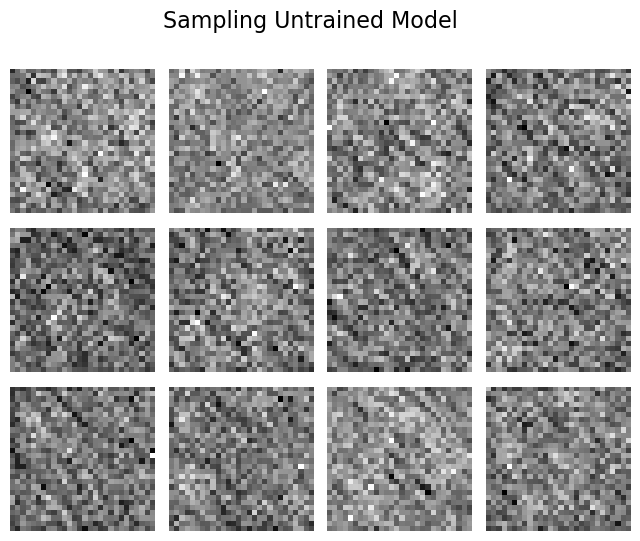

In [ ]:
def sample(n_samples=12, sample_shape=(1, 28, 28), timesteps=1000, title="None"):
    x_hat = model.sample(n_samples=n_samples, sample_shape=sample_shape, timesteps=timesteps)
    n_rows = (n_samples + 3) // 4
    fig, axs = plt.subplots(
        nrows=n_rows, ncols=4, figsize=(8, 2 * n_rows),
        subplot_kw={'xticks': [], 'yticks': [], 'frame_on': False}
    )
    for i, axis in enumerate(axs.flat[:n_samples]):
        axis.imshow(x_hat[i], cmap='binary')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.suptitle(title, fontsize=16)
    plt.show()
    plt.close()

sample(title="Sampling Untrained Model")

# <u>Training Loop</u>

Follows what we said on the previous notebook. At each epoch, we print the average loss from the last 10 iterations (i.e., moving average loss).

Epoch 1 : 


Moving Average Loss: 0.1417: 100%|██████████| 938/938 [00:48<00:00, 19.24it/s]


Epoch 2 : 


Moving Average Loss: 0.0947: 100%|██████████| 938/938 [00:48<00:00, 19.21it/s]


Epoch 3 : 


Moving Average Loss: 0.0856: 100%|██████████| 938/938 [00:48<00:00, 19.16it/s]


Epoch 4 : 


Moving Average Loss: 0.0655: 100%|██████████| 938/938 [00:48<00:00, 19.31it/s]


Epoch 5 : 


Moving Average Loss: 0.0663: 100%|██████████| 938/938 [00:48<00:00, 19.31it/s]


Epoch 6 : 


Moving Average Loss: 0.0586: 100%|██████████| 938/938 [00:48<00:00, 19.36it/s]


Epoch 7 : 


Moving Average Loss: 0.0554: 100%|██████████| 938/938 [00:48<00:00, 19.24it/s]


Epoch 8 : 


Moving Average Loss: 0.0517: 100%|██████████| 938/938 [00:48<00:00, 19.33it/s]


Epoch 9 : 


Moving Average Loss: 0.0548: 100%|██████████| 938/938 [00:48<00:00, 19.34it/s]


Epoch 10 : 


100%|██████████| 1000/1000 [00:04<00:00, 210.40it/s]


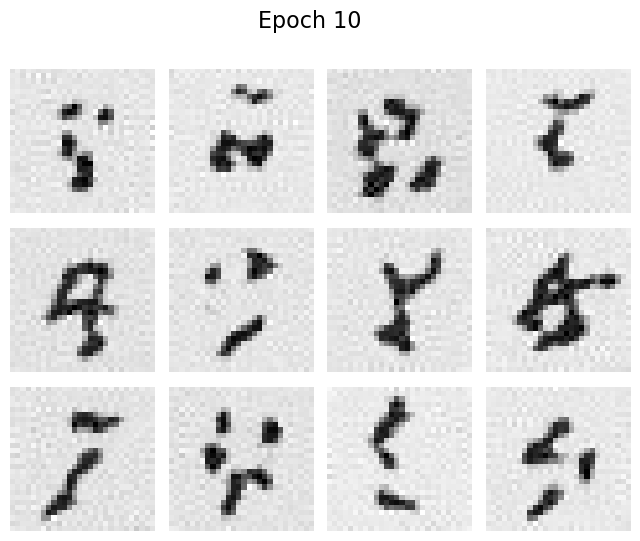

Epoch 11 : 


Moving Average Loss: 0.0442: 100%|██████████| 938/938 [00:49<00:00, 19.12it/s]


Epoch 12 : 


Moving Average Loss: 0.0491: 100%|██████████| 938/938 [00:49<00:00, 18.99it/s]


Epoch 13 : 


Moving Average Loss: 0.0424: 100%|██████████| 938/938 [00:49<00:00, 18.98it/s]


Epoch 14 : 


Moving Average Loss: 0.0442: 100%|██████████| 938/938 [00:49<00:00, 19.04it/s]


Epoch 15 : 


Moving Average Loss: 0.0390: 100%|██████████| 938/938 [00:49<00:00, 19.01it/s]


Epoch 16 : 


Moving Average Loss: 0.0410: 100%|██████████| 938/938 [00:49<00:00, 19.08it/s]


Epoch 17 : 


Moving Average Loss: 0.0481: 100%|██████████| 938/938 [00:49<00:00, 19.14it/s]


Epoch 18 : 


Moving Average Loss: 0.0385: 100%|██████████| 938/938 [00:49<00:00, 19.06it/s]


Epoch 19 : 


Moving Average Loss: 0.0456: 100%|██████████| 938/938 [00:49<00:00, 18.98it/s]


Epoch 20 : 


100%|██████████| 1000/1000 [00:04<00:00, 204.37it/s]


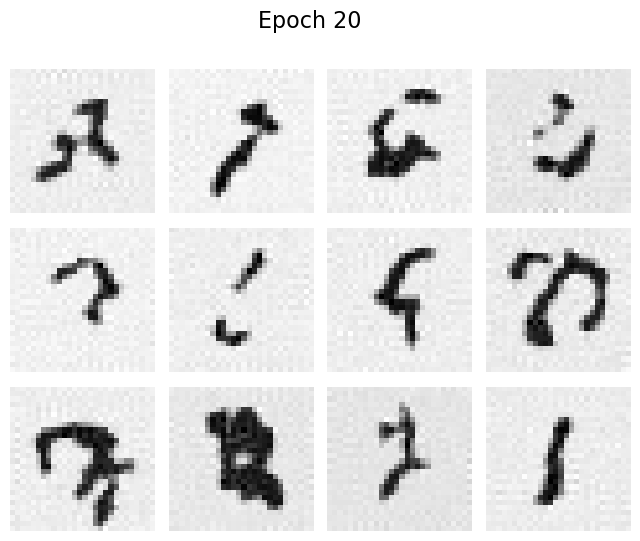

Epoch 21 : 


Moving Average Loss: 0.0375: 100%|██████████| 938/938 [00:51<00:00, 18.26it/s]


Epoch 22 : 


Moving Average Loss: 0.0372: 100%|██████████| 938/938 [00:50<00:00, 18.58it/s]


Epoch 23 : 


Moving Average Loss: 0.0375: 100%|██████████| 938/938 [00:50<00:00, 18.69it/s]


Epoch 24 : 


Moving Average Loss: 0.0388: 100%|██████████| 938/938 [00:51<00:00, 18.20it/s]


Epoch 25 : 


Moving Average Loss: 0.0430: 100%|██████████| 938/938 [00:50<00:00, 18.45it/s]


Epoch 26 : 


Moving Average Loss: 0.0426: 100%|██████████| 938/938 [00:50<00:00, 18.70it/s]


Epoch 27 : 


Moving Average Loss: 0.0374: 100%|██████████| 938/938 [00:50<00:00, 18.76it/s]


Epoch 28 : 


Moving Average Loss: 0.0361: 100%|██████████| 938/938 [00:50<00:00, 18.65it/s]


Epoch 29 : 


Moving Average Loss: 0.0387: 100%|██████████| 938/938 [00:50<00:00, 18.46it/s]


Epoch 30 : 


100%|██████████| 1000/1000 [00:04<00:00, 208.67it/s]


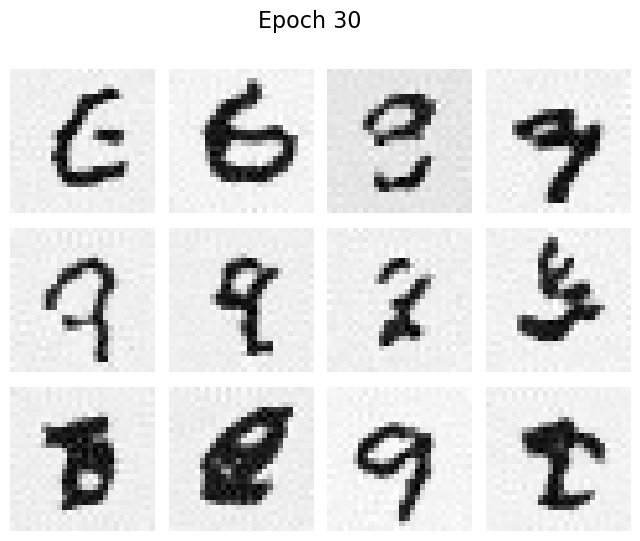

Epoch 31 : 


Moving Average Loss: 0.0400: 100%|██████████| 938/938 [00:50<00:00, 18.70it/s]


Epoch 32 : 


Moving Average Loss: 0.0362: 100%|██████████| 938/938 [00:50<00:00, 18.63it/s]


Epoch 33 : 


Moving Average Loss: 0.0327: 100%|██████████| 938/938 [00:51<00:00, 18.17it/s]


Epoch 34 : 


Moving Average Loss: 0.0347: 100%|██████████| 938/938 [00:51<00:00, 18.22it/s]


Epoch 35 : 


Moving Average Loss: 0.0359: 100%|██████████| 938/938 [00:51<00:00, 18.31it/s]


Epoch 36 : 


Moving Average Loss: 0.0312: 100%|██████████| 938/938 [00:50<00:00, 18.49it/s]


Epoch 37 : 


Moving Average Loss: 0.0339: 100%|██████████| 938/938 [00:51<00:00, 18.37it/s]


Epoch 38 : 


Moving Average Loss: 0.0366: 100%|██████████| 938/938 [00:50<00:00, 18.50it/s]


Epoch 39 : 


Moving Average Loss: 0.0311: 100%|██████████| 938/938 [00:50<00:00, 18.47it/s]


Epoch 40 : 


100%|██████████| 1000/1000 [00:04<00:00, 209.56it/s]


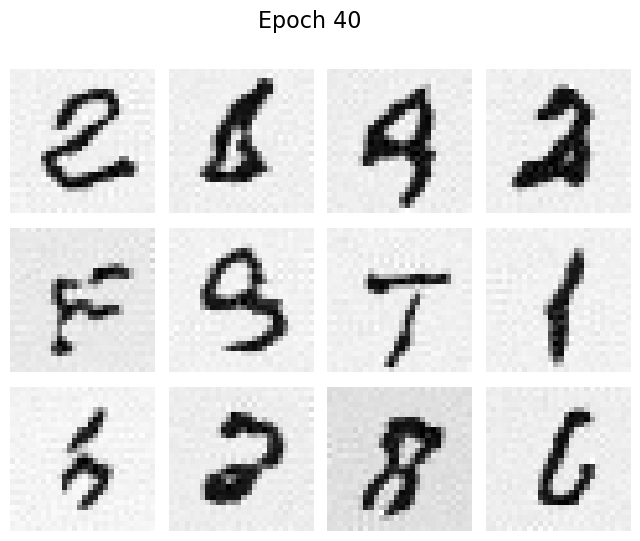

Epoch 41 : 


Moving Average Loss: 0.0340: 100%|██████████| 938/938 [00:50<00:00, 18.44it/s]


Epoch 42 : 


Moving Average Loss: 0.0349: 100%|██████████| 938/938 [00:51<00:00, 18.39it/s]


Epoch 43 : 


Moving Average Loss: 0.0306: 100%|██████████| 938/938 [00:53<00:00, 17.50it/s]


Epoch 44 : 


Moving Average Loss: 0.0346: 100%|██████████| 938/938 [00:53<00:00, 17.52it/s]


Epoch 45 : 


Moving Average Loss: 0.0294: 100%|██████████| 938/938 [00:53<00:00, 17.42it/s]


Epoch 46 : 


Moving Average Loss: 0.0371: 100%|██████████| 938/938 [00:53<00:00, 17.37it/s]


Epoch 47 : 


Moving Average Loss: 0.0339: 100%|██████████| 938/938 [00:53<00:00, 17.41it/s]


Epoch 48 : 


Moving Average Loss: 0.0348: 100%|██████████| 938/938 [00:53<00:00, 17.37it/s]


Epoch 49 : 


Moving Average Loss: 0.0305: 100%|██████████| 938/938 [00:53<00:00, 17.44it/s]


Epoch 50 : 


100%|██████████| 1000/1000 [00:04<00:00, 201.87it/s]


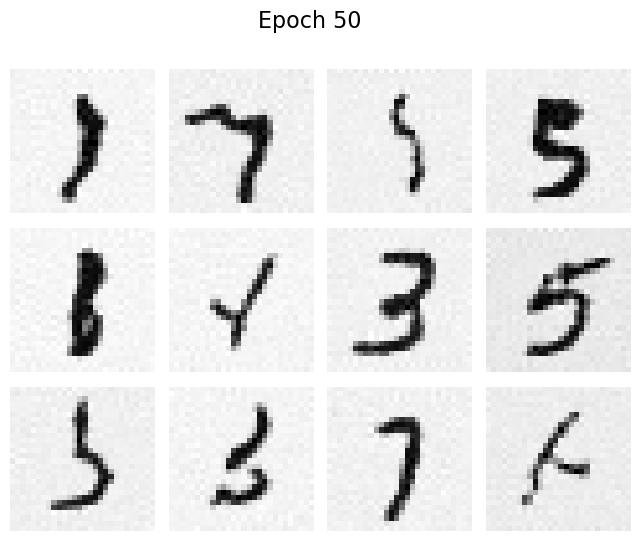

Epoch 51 : 


Moving Average Loss: 0.0277: 100%|██████████| 938/938 [00:54<00:00, 17.32it/s]


Epoch 52 : 


Moving Average Loss: 0.0318: 100%|██████████| 938/938 [00:53<00:00, 17.42it/s]


Epoch 53 : 


Moving Average Loss: 0.0292: 100%|██████████| 938/938 [00:54<00:00, 17.37it/s]


Epoch 54 : 


Moving Average Loss: 0.0316: 100%|██████████| 938/938 [00:54<00:00, 17.36it/s]


Epoch 55 : 


Moving Average Loss: 0.0289: 100%|██████████| 938/938 [00:53<00:00, 17.54it/s]


Epoch 56 : 


Moving Average Loss: 0.0344: 100%|██████████| 938/938 [00:51<00:00, 18.09it/s]


Epoch 57 : 


Moving Average Loss: 0.0317: 100%|██████████| 938/938 [00:50<00:00, 18.45it/s]


Epoch 58 : 


Moving Average Loss: 0.0331: 100%|██████████| 938/938 [00:51<00:00, 18.27it/s]


Epoch 59 : 


Moving Average Loss: 0.0304: 100%|██████████| 938/938 [00:51<00:00, 18.20it/s]


Epoch 60 : 


100%|██████████| 1000/1000 [00:04<00:00, 211.73it/s]


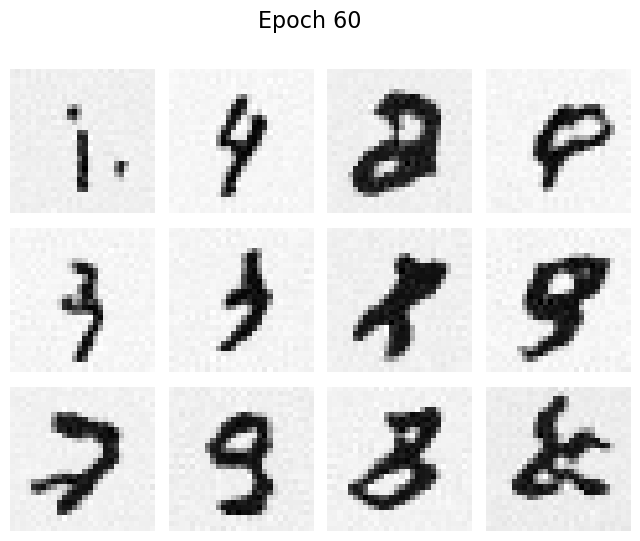

Epoch 61 : 


Moving Average Loss: 0.0288: 100%|██████████| 938/938 [00:51<00:00, 18.13it/s]


Epoch 62 : 


Moving Average Loss: 0.0308: 100%|██████████| 938/938 [00:52<00:00, 17.98it/s]


Epoch 63 : 


Moving Average Loss: 0.0297: 100%|██████████| 938/938 [00:52<00:00, 17.96it/s]


Epoch 64 : 


Moving Average Loss: 0.0302: 100%|██████████| 938/938 [00:52<00:00, 17.95it/s]


Epoch 65 : 


Moving Average Loss: 0.0297: 100%|██████████| 938/938 [00:52<00:00, 17.98it/s]


Epoch 66 : 


Moving Average Loss: 0.0306: 100%|██████████| 938/938 [00:52<00:00, 17.76it/s]


Epoch 67 : 


Moving Average Loss: 0.0301: 100%|██████████| 938/938 [00:52<00:00, 17.92it/s]


Epoch 68 : 


Moving Average Loss: 0.0293: 100%|██████████| 938/938 [00:52<00:00, 17.79it/s]


Epoch 69 : 


Moving Average Loss: 0.0273: 100%|██████████| 938/938 [00:52<00:00, 17.74it/s]


Epoch 70 : 


100%|██████████| 1000/1000 [00:04<00:00, 212.37it/s]


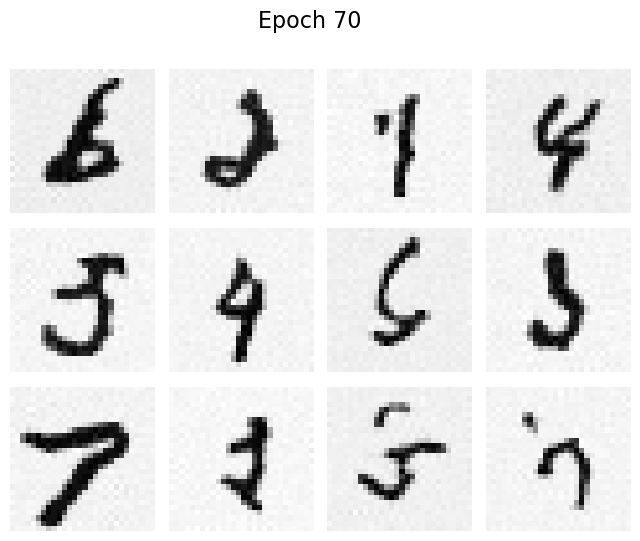

Epoch 71 : 


Moving Average Loss: 0.0320: 100%|██████████| 938/938 [00:53<00:00, 17.66it/s]


Epoch 72 : 


Moving Average Loss: 0.0331: 100%|██████████| 938/938 [00:53<00:00, 17.66it/s]


Epoch 73 : 


Moving Average Loss: 0.0285: 100%|██████████| 938/938 [00:53<00:00, 17.62it/s]


Epoch 74 : 


Moving Average Loss: 0.0301: 100%|██████████| 938/938 [00:53<00:00, 17.67it/s]


Epoch 75 : 


Moving Average Loss: 0.0325: 100%|██████████| 938/938 [00:53<00:00, 17.61it/s]


Epoch 76 : 


Moving Average Loss: 0.0278: 100%|██████████| 938/938 [00:53<00:00, 17.69it/s]


Epoch 77 : 


Moving Average Loss: 0.0284: 100%|██████████| 938/938 [00:50<00:00, 18.54it/s]


Epoch 78 : 


Moving Average Loss: 0.0297: 100%|██████████| 938/938 [00:50<00:00, 18.66it/s]


Epoch 79 : 


Moving Average Loss: 0.0287: 100%|██████████| 938/938 [00:52<00:00, 17.71it/s]


Epoch 80 : 


100%|██████████| 1000/1000 [00:04<00:00, 209.76it/s]


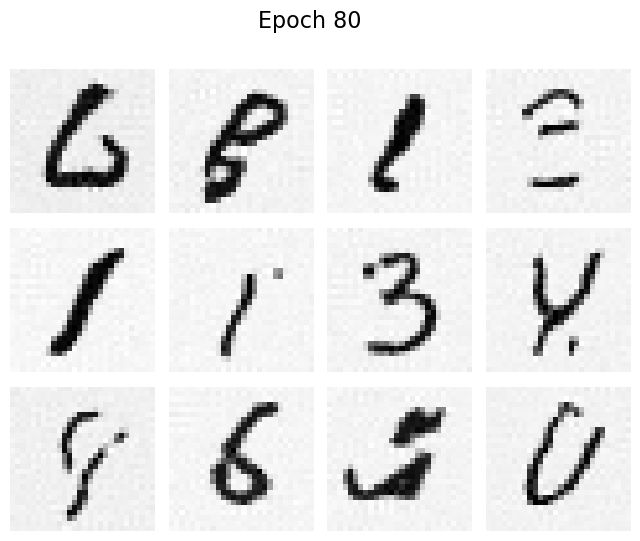

Epoch 81 : 


Moving Average Loss: 0.0293: 100%|██████████| 938/938 [00:53<00:00, 17.68it/s]


Epoch 82 : 


Moving Average Loss: 0.0317: 100%|██████████| 938/938 [00:53<00:00, 17.59it/s]


Epoch 83 : 


Moving Average Loss: 0.0310: 100%|██████████| 938/938 [00:53<00:00, 17.50it/s]


Epoch 84 : 


Moving Average Loss: 0.0261: 100%|██████████| 938/938 [00:54<00:00, 17.37it/s]


Epoch 85 : 


Moving Average Loss: 0.0267: 100%|██████████| 938/938 [00:53<00:00, 17.41it/s]


Epoch 86 : 


Moving Average Loss: 0.0270: 100%|██████████| 938/938 [00:53<00:00, 17.42it/s]


Epoch 87 : 


Moving Average Loss: 0.0273: 100%|██████████| 938/938 [00:54<00:00, 17.34it/s]


Epoch 88 : 


Moving Average Loss: 0.0290: 100%|██████████| 938/938 [00:54<00:00, 17.15it/s]


Epoch 89 : 


Moving Average Loss: 0.0266: 100%|██████████| 938/938 [00:54<00:00, 17.09it/s]


Epoch 90 : 


100%|██████████| 1000/1000 [00:04<00:00, 208.59it/s]


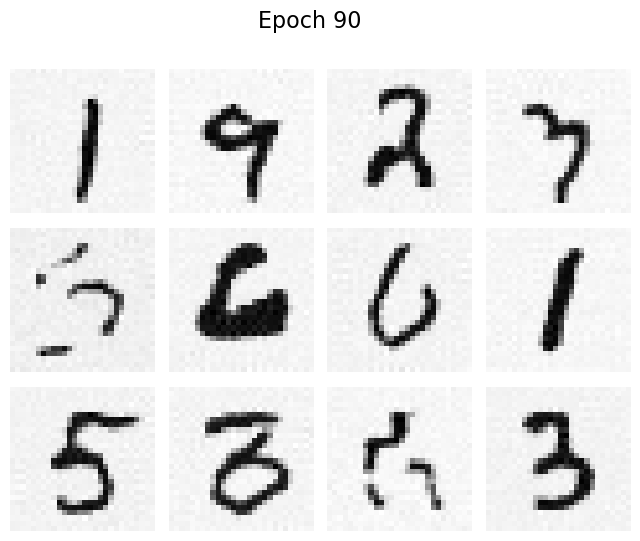

Epoch 91 : 


Moving Average Loss: 0.0257: 100%|██████████| 938/938 [00:53<00:00, 17.53it/s]


Epoch 92 : 


Moving Average Loss: 0.0269: 100%|██████████| 938/938 [00:54<00:00, 17.10it/s]


Epoch 93 : 


Moving Average Loss: 0.0294: 100%|██████████| 938/938 [00:53<00:00, 17.39it/s]


Epoch 94 : 


Moving Average Loss: 0.0314: 100%|██████████| 938/938 [00:53<00:00, 17.38it/s]


Epoch 95 : 


Moving Average Loss: 0.0302: 100%|██████████| 938/938 [00:53<00:00, 17.58it/s]


Epoch 96 : 


Moving Average Loss: 0.0285: 100%|██████████| 938/938 [00:53<00:00, 17.39it/s]


Epoch 97 : 


Moving Average Loss: 0.0295: 100%|██████████| 938/938 [00:53<00:00, 17.60it/s]


Epoch 98 : 


Moving Average Loss: 0.0279: 100%|██████████| 938/938 [00:54<00:00, 17.36it/s]


Epoch 99 : 


Moving Average Loss: 0.0317: 100%|██████████| 938/938 [00:53<00:00, 17.49it/s]


Epoch 100 : 


100%|██████████| 1000/1000 [00:04<00:00, 210.35it/s]


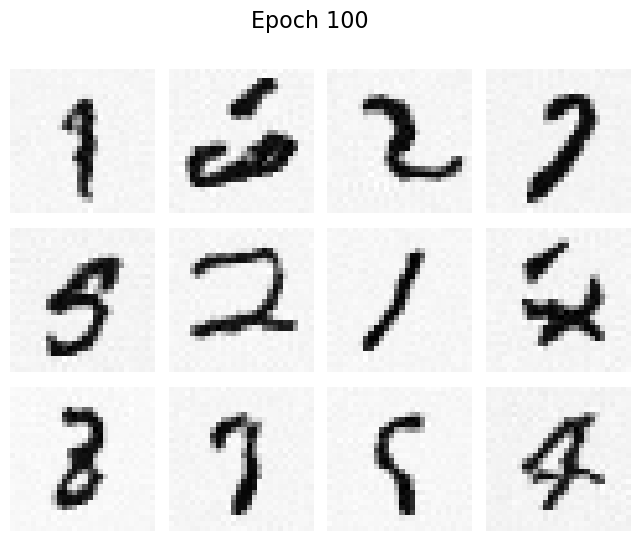

In [ ]:
def train_loop():
    losses = []
    print_every = 10
    for epoch in range(epochs):
        print(f"Epoch {epoch+1} : ")
        model.train()
        pbar = tqdm(dataloader)
        for x, _ in pbar:
            # put batch in device:
            x = x.to(device).view(-1, 1, 28, 28)
            # get t for this iteration:
            timesteps = tc.randint(1, n_T + 1, (x.shape[0],)).to(device)
            # epsilon in N(0,1)
            eps = tc.randn_like(x)
            # zero gradients
            optim.zero_grad()
            # noise the image:
            x_t = schedules["sqrt_abar"][timesteps, None, None, None] * x + \
                  schedules["sqrt_inv_abar"][timesteps, None, None, None] * eps
            # normalize t:
            t = timesteps/n_T
            # get model's prediction of epsilon:
            eps_hat = model(x_t, t)
            # compute loss:
            loss = loss_fn(eps_hat, eps)
            # backpropagate
            loss.backward()
            # log loss:
            losses.append(loss.item())
            # average loss for last 10 iterations:
            avg_loss = np.asarray(losses)[-10:].mean()
            # print
            pbar.set_description(f"Moving Average Loss: {avg_loss:.4f}")
            # update weights:
            optim.step()
        # generate samples:
        if (epoch + 1) % print_every == 0:
            with tc.no_grad():
                model.eval()
                sample(title=f"Epoch {epoch+1}")
                model.train()
    return losses

train_losses = train_loop()

### <u>Plot Loss</u>

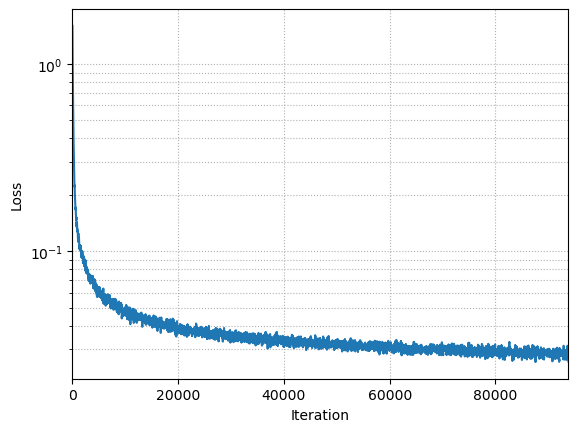

In [ ]:
smooth_losses = savgol_filter(x=train_losses, window_length=201, polyorder=7)
plt.figure()
plt.semilogy(smooth_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.xlim([0, len(train_losses)])
plt.grid(linestyle=':', which='both')
plt.show()
plt.close()